# Spotting the Problem

It is good to know how well the trains run according to the schedule and the on-time-performance impact on the customers of BART. What is even better is figuring out what are the potential problems where delays are introduced.

Rather than look at entire journey, we look at the individual segments. Delays are introduced in runs between stations. These stack up and eventually add upto significant impact on the total journey times for customers. So in this notebook, we will walk through how we can identify potential bottlenecks.

We do this by comparing the scheduled travel times with the actual travel times between pairs of stations. The travel times here may identify segments that have chronic issues/delays and help direct the next step analysis. 

In [1]:
import pandas as pd
# Configure some display options for panda frames to ensure we see all columns and rows when needed.
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 6)
pd.set_option('display.max_colwidth', -1)

import datetime as dt

# Ensure we embedd the graphs we generate within the Notebook
%matplotlib inline

import numpy as np
from scipy import stats

import seaborn as sns
sns.set(color_codes=True)
#sns.set_context("notebook", font_scale=1.1)
#sns.set_style("ticks")

import pickle

import pprint

In [2]:
class TravelStatistics(object):
    def __init__(self, start, end, list_travel_times):
        """Given a TravelRecord with multiple trips, generates statistics including:
         * stats.describe.
         * median (i.e. p50
         * p90
         * p99
         * p99.9
         """
        self._start = start
        self._end = end
        np_array = np.sort(np.fromiter(list_travel_times, np.float))
        
        percentiles = np.percentile(np_array, [50, 75, 90, 95, 99])
        self._p50 = percentiles[0]
        self._p75 = percentiles[1]
        self._p90 = percentiles[2]
        self._p95 = percentiles[3]
        self._p99 = percentiles[4]
        
        stats_obj = stats.describe(np_array)
        self._nobs = stats_obj.nobs
        self._min = stats_obj.minmax[0]
        self._max = stats_obj.minmax[1]
        self._mean = stats_obj.mean
        self._variance = stats_obj.variance
        self._skewness = stats_obj.skewness
        self._kurtosis = stats_obj.kurtosis
        self._mode = stats.mode(np_array)
        #DescribeResult(nobs=238, minmax=(150.0, 4908.0), mean=649.90756302521004, 
        # variance=391391.05471049179, skewness=2.975446304980173, kurtosis=11.555424995051435)
        
    def __str__(self):
        ret = "start={}, end={}".format(self._start, self._end)
        ret += ", nobs={}, min={}, max={}, mode={}".format(self._nobs, self._min, self._max, self._mode)
        ret += ", p50={}, p75={}, p90={}, p95={}, p99={}".format(self._p50, self._p75, self._p90, self._p95, self._p99)
        ret += ", mean={}, variance={}".format(self._mean, self._variance)
        ret += ", skewness={}, kurtosis={}".format(self._skewness, self._kurtosis)        
        return ret

    def __repr__(self):
        return self.__str__() 



In [3]:
class TravelRecord(object):
    def __init__(self, row_a, row_b):
        """Represents a TravelRecord between two locations, including the start, end times as well as durations."""
        self._location_a = row_a['location']
        self._location_b = row_b['location']
        self._start_time = row_a['received_time']
        self._end_time = row_b['received_time']
        self._travel_time_secs = (self._end_time - self._start_time).total_seconds()
        
    def __str__(self):
        ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return ret
    
    def __repr__(self):
        #ret = "{} @ {} --[{}]--> {} @ {}".format(self._location_a, self._start_time, self._travel_time_secs, self._location_b, self._end_time)
        return self.__str__()

## Datasets

First we will load the the datasets we produced in other notebooks.

In [4]:
map_actual_travel_times = {}
with open('actual_travel_time_stats2.pickle', 'rb') as handle:
    map_actual_travel_times = pickle.loads(handle.read())

In [5]:
pprint.pprint(map_actual_travel_times['M80']['M90'])

[start=M80, end=M90, nobs=1648, min=7.0, max=78499.0, mode=ModeResult(mode=array([ 507.]), count=array([10])), p50=543.5, p75=768.0, p90=1381.3, p95=2175.4, p99=4124.23, mean=791.399271845, variance=4547574.5788, skewness=29.9580615015, kurtosis=1071.08818063]


In [6]:
map_scheduled_travel_times = {}
with open('schedule_travel_time_stats.pickle', 'rb') as handle:
    map_scheduled_travel_times = pickle.loads(handle.read())

In [7]:
pprint.pprint(map_scheduled_travel_times['M80']['M90'])

[start=M80, end=M90, nobs=543, min=226.0, max=256.0, mode=ModeResult(mode=array([ 256.]), count=array([299])), p50=256.0, p75=256.0, p90=256.0, p95=256.0, p99=256.0, mean=242.519337017, variance=223.102485168, skewness=-0.203625508646, kurtosis=-1.95853665223]


In [8]:
map_travel_records = {}
with open('actual_travel_time2.pickle', 'rb') as handle:
    map_travel_records = pickle.loads(handle.read())

In [9]:
time_table = pd.read_csv('tt_of_interest_no_index.csv')

In [10]:
time_table.head()

,SCH_DAY_TYPE_CODE,ROUTE_B_NUMBER,TRAIN_NUMBER,RUN_U_NUMBER,STATION_O_NUMBER,STATION_CH3_ABBR,STATION_NAME,DOOR_CLOSE_TIME,DOOR_CLOSE_TSEC,DOOR_OPEN_TSEC,LINE_NUMBER,ROUTE_ABBR,MAP_COLOR_NAME,FROM_STATION_O_NUM,TO_STATION_O_NUM,FROM_STATION_CH3_ABBR,TO_STATION_CH3_ABBR,FROM_STATION,TO_STATION
0,SA,1,361,5,41,C80,WEST PITTSBURG,2017-08-15 06:58:23,25103,24983.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
1,SA,1,361,5,40,C70,NORTH CONCORD,2017-08-15 07:04:30,25470,25455.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
2,SA,1,361,5,19,C60,CONCORD,2017-08-15 07:08:04,25684,25669.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
3,SA,1,361,5,18,C50,PLEASANT HILL,2017-08-15 07:13:28,26008,25993.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT
4,SA,1,361,5,17,C40,WALNUT CREEK,2017-08-15 07:16:05,26165,26150.0,3,CD,YELLOW,41,38,C80,Y10,WEST PITTSBURG,S.F. AIRPORT


Lets build up a look up table to quickly identify the STATION_NAME and MAP_COLOR_NAME

In [11]:
station_name_color = time_table[['STATION_CH3_ABBR','STATION_NAME', 'MAP_COLOR_NAME']].sort_values('STATION_CH3_ABBR')
station_name_color = station_name_color.drop_duplicates()
station_name_color.set_index('STATION_CH3_ABBR', inplace=True)
station_name_color.shape

(107, 2)

In [12]:
type(station_name_color.loc['M10'].STATION_NAME[0])

str

In [13]:
station_name_color

,STATION_NAME,MAP_COLOR_NAME
STATION_CH3_ABBR,,
A10,LAKE MERRITT,ORANGE
A10,LAKE MERRITT,GREEN
A10,LAKE MERRITT,BLUE
A20,FRUITVALE,BLUE
A20,FRUITVALE,GREEN
A20,FRUITVALE,ORANGE
A30,COLISEUM,GREEN
A30,COLISEUM,ORANGE
A30,COLISEUM,BLUE


## Comparison


In [14]:
match = 0
no_match = 0
for start, nested in map_actual_travel_times.iteritems():
    for end, actual_travel_stats in nested.iteritems():
        
        if start in map_scheduled_travel_times:
            if end in map_scheduled_travel_times[start]:
                
                start_name = station_name_color.loc[start].STATION_NAME
                if type(start_name) is not str:
                    start_name = start_name[0]
                end_name = station_name_color.loc[end].STATION_NAME
                if type(end_name) is not str:
                    end_name = end_name[0]
                
                schedule_travel_stats = map_scheduled_travel_times[start][end][0]
                expected_duration = schedule_travel_stats._mode.mode[0]
                actual_duration_median = actual_travel_stats[0]._p50
                print "({}){} -> ({}){}: Expected={} vs {}=Actual".format(start, start_name,end, end_name, expected_duration,actual_duration_median)
                #print "Match: {} -> {}: {}\n".format(start, end, travel_stats)
                #print "   vs: {}\n".format(schedule_travel_stats)
                match += 1
            else:
                no_match += 1
        else:
            no_match += 1
            
print "There were {} matches and {} no matches".format(match, no_match)

(K10)12TH STREET OAKLAND  -> (M10)OAKLAND WEST        : Expected=268.0 vs 772.0=Actual
(K10)12TH STREET OAKLAND  -> (K20)19TH STREET OAKLAND : Expected=103.0 vs 84.0=Actual
(M50)16TH STREET MISSION  -> (M60)24TH STREET MISSION : Expected=121.0 vs 237.0=Actual
(M50)16TH STREET MISSION  -> (M40)CIVIC CENTER        : Expected=142.0 vs 296.0=Actual
(C50)PLEASANT HILL        -> (C40)WALNUT CREEK        : Expected=157.0 vs 374.5=Actual
(C50)PLEASANT HILL        -> (C60)CONCORD             : Expected=299.0 vs 937.5=Actual
(L10)CASTRO VALLEY        -> (A50)BAY FAIR            : Expected=285.0 vs 808.0=Actual
(A80)UNION CITY           -> (A90)FREMONT             : Expected=270.0 vs 730.5=Actual
(A80)UNION CITY           -> (A70)SOUTH HAYWARD       : Expected=311.0 vs 811.5=Actual
(M30)POWELL STREET        -> (M40)CIVIC CENTER        : Expected=90.0 vs 153.0=Actual
(M30)POWELL STREET        -> (M20)MONTGOMERY STREET   : Expected=101.0 vs 153.0=Actual
(A50)BAY FAIR             -> (A60)HAYWARD    

## Distributions and Graphs


Actual Times:
[start=K10, end=M10, nobs=764, min=189.0, max=18903.0, mode=ModeResult(mode=array([ 419.]), count=array([5])), p50=772.0, p75=1059.0, p90=1456.4, p95=2219.8, p99=6359.06, mean=957.760471204, variance=1354974.22695, skewness=7.80605395233, kurtosis=90.7867627006]
Schedule Times:
[start=K10, end=M10, nobs=292, min=268.0, max=268.0, mode=ModeResult(mode=array([ 268.]), count=array([292])), p50=268.0, p75=268.0, p90=268.0, p95=268.0, p99=268.0, mean=268.0, variance=0.0, skewness=0.0, kurtosis=-3.0]
2219.8


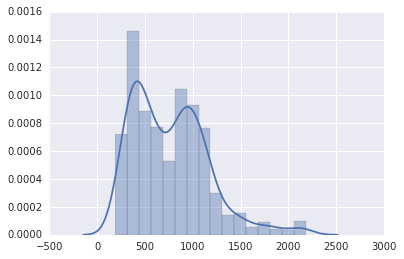

In [15]:
#pprint.pprint(map_travel_records['R20']['R10'])
A = 'K10'
B = 'M10'
list_travel_recs = map_travel_records[A][B]
actual_stats = map_actual_travel_times[A][B]
schedule_times = map_scheduled_travel_times[A][B]

print "Actual Times:"
pprint.pprint(actual_stats)
print "Schedule Times:"
pprint.pprint(schedule_times)

cutoff = actual_stats[0]._p95
print cutoff
list_times = [x._travel_time_secs for x in list_travel_recs if (x._travel_time_secs < cutoff)]

#pprint.pprint(list_times)
sns_plot = sns.distplot(list_times)
sns_plot.get_figure().savefig("plots/{}_to_{}.png".format(A, B))

## Maps


In [16]:
bart_locations = pd.read_csv('bart_locations.csv')
bart_locations.head()

,station_q_number,Country,station_ch5_abbr,station_ch8_abbr,station_p_number,station_o_number,city,station_r_number,county,bart_station_geo_country_geo_city,station_abbr,bart_station_geo_country_geo_postcode,geo_address,line_number,bart_station_geo_country_geo_region,id,state,abbr,bart_station_geo_country_geo_regionid,station_name,address,bart_station_geo_country_geo_subregion,bart_station_geo_country_geo_geocode,station_ch3_abbr,bart_station_geo_country_geo_country,bart_station_geo_country_geo_subregionid,zipcode,plat1_displ_number,gtfs_latitude,name,station_m_number,gtfs_longitude,plat4_displ_number,station_ch4_abbr,plat2_displ_number,plat3_displ_number,Source_data_set|
0,27,United States,MONTG,MONTGMRY,27.0,27.0,San Francisco,41.0,sanfrancisco,San Francisco,MT,94172.0,37.789256 -122.401407,1.0,California,MT,CA,MONT,5332921.0,MONTGOMERY STREET,598 Market Street,City And County Of San Francisco,37.77493 -122.41942,M20,US,5391997.0,94104.0,16.0,37.789256,MONTGOMERY ST.,31.0,-122.401407,0.0,MONT,17.0,0.0,bart_locations|station_list
1,32,United States,GLNPK,GLEN PRK,32.0,32.0,San Francisco,46.0,sanfrancisco,San Francisco,GP,94172.0,37.732921 -122.434092,1.0,California,GP,CA,GLEN,5332921.0,GLEN PARK,2901 Diamond Street,City And County Of San Francisco,37.77493 -122.41942,M70,US,5391997.0,94131.0,6.0,37.732921,GLEN PARK,36.0,-122.434092,0.0,GLEN,7.0,0.0,station_list|bart_locations
2,4,United States,NBERK,NO BRKLY,4.0,22.0,Berkeley,13.0,alameda,Berkeley,NB,94712.0,37.87404 -122.283451,4.0,California,NB,CA,NBRK,5332921.0,NORTH BERKELEY,1750 Sacramento Street,Alameda County,37.87159 -122.27275,R30,US,5322745.0,94702.0,46.0,37.874040,NORTH BERKELEY,26.0,-122.283451,0.0,NBER,47.0,0.0,station_list|bart_locations
3,38,United States,NCONC,N CONCRD,35.0,40.0,Concord,31.0,contracosta,Concord,NC,94524.0,38.003275 -122.024597,3.0,California,NC,CA,NCON,5332921.0,NORTH CONCORD,3700 Port Chicago Highway,Contra Costa County,37.97798 -122.03107,C70,US,5339268.0,94520.0,0.0,38.003275,NORTH CONCORD/MARTINEZ,22.0,-122.024597,0.0,NCON,0.0,0.0,station_list|bart_locations
4,40,United States,WDUBL,W DUBLIN,38.0,45.0,Dublin,9.0,alameda,Dublin,WD,94568.0,37.699759 -121.928099,7.0,California,WD,CA,WDUB,5332921.0,WEST DUBLIN / PLEAS,6501 Golden Gate Drive,Alameda County,37.70215 -121.93579,L20,US,5322745.0,94568.0,0.0,37.699759,WEST DUBLIN/PLEASANTON,NaN,-121.928099,0.0,WDBL,0.0,0.0,station_list|bart_locations


In [17]:

bart_loi = bart_locations[['station_ch3_abbr','gtfs_latitude', 'gtfs_longitude', 'station_name']].dropna()

lat_min = bart_loi['gtfs_latitude'].min()
lat_max = bart_loi['gtfs_latitude'].max()

lon_min = bart_loi['gtfs_longitude'].min()
lon_max = bart_loi['gtfs_longitude'].max()

lat_c = (lat_max + lat_min)/2
lon_c =  (lon_max + lon_min)/2

print (lat_c, lon_c)

(37.788134499999998, -122.18472385)


In [18]:
bart_loi.head()

,station_ch3_abbr,gtfs_latitude,gtfs_longitude,station_name
0,M20,37.789256,-122.401407,MONTGOMERY STREET
1,M70,37.732921,-122.434092,GLEN PARK
2,R30,37.874040,-122.283451,NORTH BERKELEY
3,C70,38.003275,-122.024597,NORTH CONCORD
4,L20,37.699759,-121.928099,WEST DUBLIN / PLEAS


In [19]:
def get_lat_lon_for(station_id, jitter=0):
    '''Returns a tuple of (lat, lon) for a given station_id'''
    try:
        lat = bart_loi.loc[bart_loi['station_ch3_abbr'] == station_id, 'gtfs_latitude'].values[0] + jitter
        lon = bart_loi.loc[bart_loi['station_ch3_abbr'] == station_id, 'gtfs_longitude'].values[0] + jitter
        return (lat, lon)
    except Exception as e:
        print "Couldn't find lat/lon for station = {}".format(station_id)
        return (0,0)

def get_station_name_for(station_id):
    '''Returns a tuple of (lat, lon) for a given station_id'''
    try:
        return bart_loi.loc[bart_loi['station_ch3_abbr'] == station_id, 'station_name'].values[0]
    except Exception as e:
        print "Couldn't find name for station = {}".format(station_id)
        return "UNKNOWN"

#Now some lines
A = 'K10'
B = 'M10'

#bart_loi[('station_ch3_abbr' == A)]

#row = bart_loi.loc[bart_loi['station_ch3_abbr'] == A][['gtfs_latitude', 'gtfs_longitude']]
#bart_loi.loc[bart_loi['station_ch3_abbr'] == B]

print get_lat_lon_for(A)
print get_station_name_for(A)
print get_lat_lon_for(B)
print get_station_name_for(B)

(37.803664000000005, -122.27160400000001)
12TH STREET OAKLAND
(37.804674759999997, -122.29458219999999)
OAKLAND WEST


In [20]:
import base64
from folium import IFrame

import matplotlib.pyplot as plt

PLOT_DIR_PREFIX = 'plots'
IMAGE_RESOLUTION = 75
IMAGE_WIDTH = 7
IMAGE_HEIGHT = 3


def safe_get_from_map(map_to_check, key_a, key_b):
    if key_a in map_to_check:
        if key_b in map_to_check[key_a]:
            return map_to_check[key_a][key_b]
    return None

def generate_stats_image(A, B):
    list_travel_recs = safe_get_from_map(map_travel_records, A, B)
    actual_stats = safe_get_from_map(map_actual_travel_times, A, B)
    schedule_times = safe_get_from_map(map_scheduled_travel_times, A, B)
    
    if list_travel_recs is None:
        "Missing entry in map_travel_records for {} -> {}. Skipping".format(A, B)
        return False
    if actual_stats is None:
        "Missing entry in map_actual_travel_times for {} -> {}. Skipping".format(A, B)
        return False
    if schedule_times is None:
        "Missing entry in map_scheduled_travel_times for {} -> {}. Skipping".format(A, B)
        return False
    
    # We will use a p95 cut-off or, the long tail can make the chart hard to see
    # We are essentially excluding the really large outliers
    cutoff = actual_stats[0]._p95
    list_times = [x._travel_time_secs for x in list_travel_recs if (x._travel_time_secs < cutoff)]

    # Start by clearning the plot and setting figure size.
    plt.clf()
    plt.figure(figsize=(IMAGE_WIDTH, IMAGE_HEIGHT))
    #ax = plt.axes()
    #sns_plot = sns.distplot(list_times, ax=ax)
    #label_a = get_station_name_for(A)
    #label_b = get_station_name_for(B)
    #ax.set_title("Trip distribution {} to {}".format(label_a, label_b))
    #ax.set(xlabel='Time (seconds)', ylabel='Percentage of Trips within P95')
    sns_plot = sns.distplot(list_times)
    fig = sns_plot.get_figure()
    fig.savefig("{}/{}_to_{}.png".format(PLOT_DIR_PREFIX, A, B), dpi=IMAGE_RESOLUTION)
    plt.close()
    return True
    

def get_image_iframe_popup(A, B):
    file_name = '{}/{}_to_{}.png'.format(PLOT_DIR_PREFIX, A, B)
    label_a = get_station_name_for(A)
    label_b = get_station_name_for(B)
    encoded = base64.b64encode(open(file_name, 'rb').read()).decode()
    html = '<h2>From {} to {}</h2><hr></h1><img src="data:image/png;base64,{}">'.format
    iframe = IFrame(html(label_a, label_b, encoded), width=(IMAGE_WIDTH*IMAGE_RESOLUTION)+20, height=(IMAGE_HEIGHT*IMAGE_RESOLUTION)+20)
    popup = folium.Popup(iframe, max_width=2650)
    return popup

In [21]:
def get_rgb_color_for(level):
    pal = sns.color_palette("OrRd", 10)
    return pal.as_hex()[level]

def draw_travel_lines(folium_map, A, B):
    # 1. Generate the image for A -> B
    if generate_stats_image(A, B):
        popup_iframe = get_image_iframe_popup(A, B)
    else:
        popup_iframe = "Missing stats image."
        
    points = []
    points.append(get_lat_lon_for(A, 0.0005))
    points.append(get_lat_lon_for(B, 0.0005))
    folium.PolyLine(points, color=get_rgb_color_for(9), weight=7, opacity=0.7, popup=popup_iframe).add_to(folium_map)

    # 2. Now the image for B -> A
    if generate_stats_image(B, A):
        popup_iframe = get_image_iframe_popup(B, A)
    else:
        popup_iframe = "Missing stats image."
        
    points = []
    points.append(get_lat_lon_for(A, -0.0005))
    points.append(get_lat_lon_for(B, -0.0005))
    folium.PolyLine(points, color=get_rgb_color_for(1), weight=7, opacity=0.7, popup=popup_iframe).add_to(folium_map)


In [22]:

def plot_travel_times(folium_map):
    match = 0
    no_match = 0
    for start, nested in map_actual_travel_times.iteritems():
        for end, actual_travel_stats in nested.iteritems():
            if match > 5:
                break
            if start in map_scheduled_travel_times:
                if end in map_scheduled_travel_times[start]:
                    print ".",
                    draw_travel_lines(map2, start, end)
                    match += 1
                else:
                    no_match += 1
            else:
                no_match += 1

    print "There were {} matches and {} no matches".format(match, no_match)

In [23]:
import folium

# tiles='Stamen Terrain'
# tiles='CartoDB dark_matter' - > Black
# tiles='CartoDB positron'
#
#
# station_ch3_abbr,
# gtfs_latitude,
# gtfs_longitude,
# station_name,
# name
#
map2 = folium.Map(location=[lat_c, lon_c], tiles='CartoDB positron', zoom_start=14)
marker_cluster = folium.MarkerCluster().add_to(map2)
for idx, row in bart_loi.iterrows():
    #print row['station_ch3_abbr'], row['gtfs_latitude']
    lon = row['gtfs_longitude']
    lat = row['gtfs_latitude']
    label = row['station_name']
    folium.Marker([lat, lon], popup=label).add_to(marker_cluster)
plot_travel_times(map2)

#A = 'K10'
#B = 'M10'
#draw_travel_lines(map2, A, B)
#
#A = 'M10'
#B = 'M16'
#draw_travel_lines(map2, A, B)
#
#A = 'M10'
#B = 'A10'
#draw_travel_lines(map2, A, B)
#
map2.save('test_map.html')


. . . . . . There were 6 matches and 4 no matches


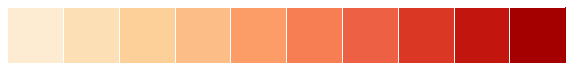

In [24]:
sns.palplot(sns.color_palette("OrRd", 10))

In [25]:
map2

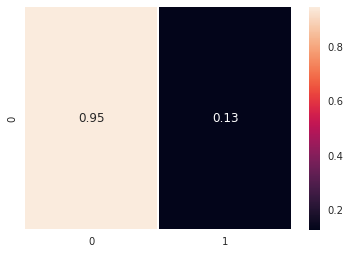

In [26]:
import seaborn as sns
data = np.random.rand(1,2)
sns.heatmap(data, annot=True,  linewidths=.5)

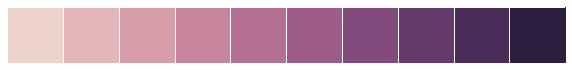

In [27]:
sns.palplot(sns.cubehelix_palette(10))

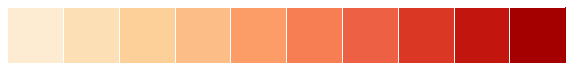

In [28]:
# https://chrisalbon.com/python/seaborn_color_palettes.html
sns.palplot(sns.color_palette("OrRd", 10))


In [29]:
sns.color_palette("OrRd", 10)

[(0.99717031927669753, 0.92618224200080423, 0.82362169448067157),
 (0.99434063855339494, 0.87504806588677797, 0.711326430124395),
 (0.99215686321258545, 0.81522492450826312, 0.60281432586557726),
 (0.99215686321258545, 0.74140716650906735, 0.5260438575464137),
 (0.98965013518052947, 0.61802385975332819, 0.40985776314548417),
 (0.96984237011741192, 0.4963475778991101, 0.32496733069419859),
 (0.92950404111076801, 0.37896194370353925, 0.26911189196740881),
 (0.85863899343154015, 0.22246828552554634, 0.14805075201918097),
 (0.76452135198256554, 0.083414073142350886, 0.053871587941459576),
 (0.6451826349192975, 0.0, 0.0)]

In [30]:


#    color = sns.color_palette("OrRd", 10)[level]
#    print color[0] *255
#    ret = (color[0]*255,color[1]*255,color*[2])
#    return ret

get_rgb_color_for(1)
get_rgb_color_for(2)

u'#fdd09a'

TODO;
1. Clean up code
2. Generate delay distrubution wrt to the (schedule + 2 mins)
3. Table of stats wrt to the actual median
4. Identify Problem pairs and color routes with heat-map colors
   - bucket colors by the numebr of mins beyond the expectation + 2 mins.
